In [65]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Polinomio Autoregresivo (Modelo ARX)

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas y el objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$.

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+b_2u[k-2]+...+b_{n_b}u[k-{n_b}] + e[k]$$

Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[k] = \phi.\theta + e[k]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$


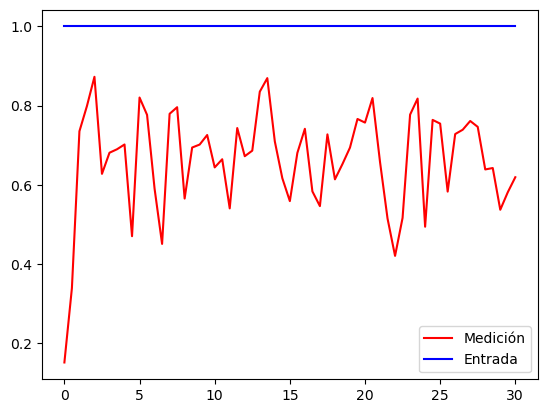

In [95]:
## Sistema de segundo orden en tiempo continuo
g = control.tf([6],[2,3,9])
#g = control.tf([4],[1,10,2])
t0 = 0
tf = 30
dt = 0.5
N = int((tf-t0)/dt)+1
t = np.linspace(t0,tf,N)
_,y = control.step_response(g,t)
u = np.ones(N);

## Ruido para simular la señal de salida capturada "yn"
r = 0.1
e = np.random.normal(0,r,size=N)

yn = y+e
plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')
plt.legend(['Medición','Entrada'])

## Definir la matriz de regresión
$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

In [102]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
    
## Creación del vector phi
phi = np.array([-y_1,-y_2,u,u_1]).transpose()
phi
#phi = np.array([-y_1,-y_2,u_1]).transpose()

array([[-0.        , -0.        ,  1.        ,  0.        ],
       [-0.15136539, -0.        ,  1.        ,  1.        ],
       [-0.33916954, -0.15136539,  1.        ,  1.        ],
       [-0.73536155, -0.33916954,  1.        ,  1.        ],
       [-0.7990468 , -0.73536155,  1.        ,  1.        ],
       [-0.87288421, -0.7990468 ,  1.        ,  1.        ],
       [-0.62775545, -0.87288421,  1.        ,  1.        ],
       [-0.68110305, -0.62775545,  1.        ,  1.        ],
       [-0.6898771 , -0.68110305,  1.        ,  1.        ],
       [-0.7019468 , -0.6898771 ,  1.        ,  1.        ],
       [-0.47029207, -0.7019468 ,  1.        ,  1.        ],
       [-0.82056193, -0.47029207,  1.        ,  1.        ],
       [-0.7767843 , -0.82056193,  1.        ,  1.        ],
       [-0.59041702, -0.7767843 ,  1.        ,  1.        ],
       [-0.45083153, -0.59041702,  1.        ,  1.        ],
       [-0.7794252 , -0.45083153,  1.        ,  1.        ],
       [-0.79610524, -0.

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$


La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad.

In [97]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.33425775,  0.14305689,  0.15136539,  0.39115122])

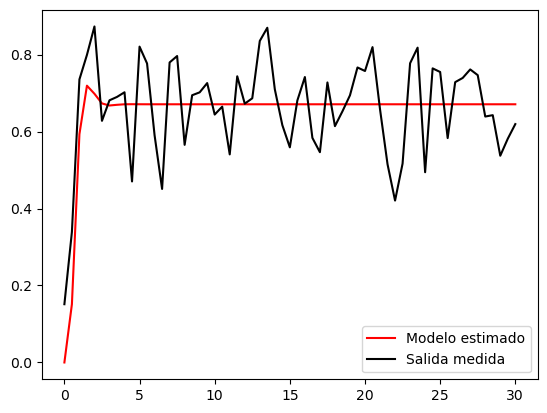

In [103]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## EVALUAR LA SELECCIÓN DEL TIEMPO DE MUESTREO

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1+ theta[3]*z**-2

G = B/A
G = G.simplify()
G_e = control.tf([theta[2],theta[3]],[1,theta[0],theta[1]],dt)

H = 1/A
H = H.simplify()
H_e = control.tf([1,0,0],[1,theta[0],theta[1]],dt)

## Intento 1 - respuesta discreta.
## Averiguar cómo obtener los mismos datos que yn

_,ye = control.step_response(G_e,t)
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])
#plt.xlim([0, t[len(t)-1]])   

ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)


In [104]:
## Función de transferencia G(z)
print(G)
print(G_e)
gd = control.c2d(g,dt)
print(gd)

print(ECM)

(0.15136538518508*z + 0.391151223732855)/(z**2 - 0.334257752886419*z + 0.143056889539055)

   0.1514 z + 0.3912
-----------------------
z^2 - 0.3343 z + 0.1431

dt = 0.5


   0.2711 z + 0.2093
-----------------------
z^2 - 0.7517 z + 0.4724

dt = 0.5

0.01393523547457128


(array([0.16712888+0.3393005j, 0.16712888-0.3393005j]),
 array([-2.5841524+0.j]))

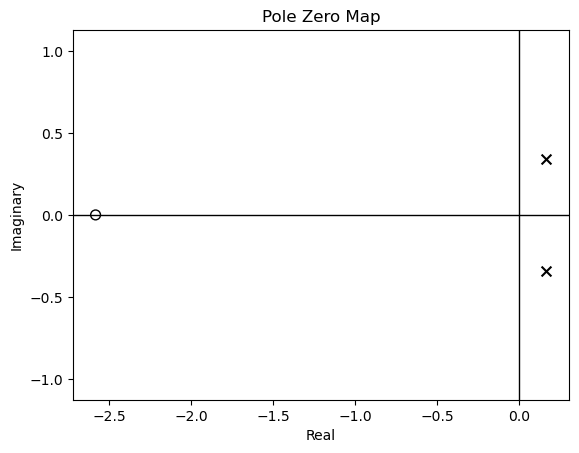

In [105]:
control.pzmap(G_e)

(array([0.37586854+0.57540368j, 0.37586854-0.57540368j]),
 array([-0.77211532+0.j]))

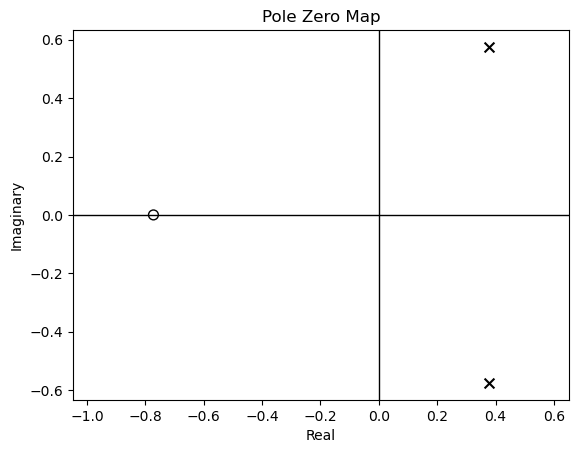

In [106]:
control.pzmap(gd)